In [202]:
%matplotlib inline
from sensible_raw.loaders import loader
import pandas
from collections import defaultdict, Counter
import matplotlib.pylab as plt
import seaborn as sns
import subprocess
import os, sys
import json
import datetime
from datetime import datetime as dt
from scipy import stats
import numpy as np

# Feature extraction from bluetooth data

### Features to extract
    
    1. Sociability (avg daily degree)
    3. Predictability
    (4. Number of cores)

In [197]:
# Load bluetooth data
columns_bluetooth, data_bluetooth = loader.load_data("bluetooth_2", "february_2014")
dict_tmp = {}
for column, array in zip(columns_bluetooth, data_bluetooth):
    dict_tmp[column] = array
df_bluetooth = pandas.DataFrame(dict_tmp)

In [233]:
# Filter data. Remove non-phone and > 1.5 m connections.
is_phone = lambda x: (x & 0x001F00) == 0x000200

df_bluetooth = df_bluetooth[(is_phone(df_bluetooth['class'])==True) & (df_bluetooth['rssi'] > -75)]

In [215]:
users = list(set(df_bluetooth['user']))

In [199]:
print "N in-study connections:", len(df_bluetooth[df_bluetooth['bt_mac'] >= 0])
print "N out-study connections:", len(df_bluetooth[df_bluetooth['bt_mac'] < 0])

N in-study connections: 440998
N out-study connections: 54226


In [201]:
print "Number of participants:", len(data_main)
print "Number of interactions:", len(list(df_bluetooth['user']))

Number of participants: 606
Number of interactions: 495224


## 3. Predictability

#### To compute this feature, the strategy is as follows:
1. Compute the entropy.
    1. Create counter of every social state (connection)
    2. Normalise with all connections for user to get probability
    3. Compute entropy using $S_i^{unc}=\sum_j^{N_i} =p_j\log_2{p_j}$
2. Solve a limiting case Fano's inequality to find the predictability.

In [225]:
def compute_entropy(p):
    Ni = len(p); entropy = 0.0
    for j in range(Ni):
        entropy -= p[j]*np.log(p[j])
    return entropy


user_entropy = {}
user_connections = {}
        
for i in users:
    state_counter = Counter()

    connections = list(df_bluetooth[df_bluetooth['user'] == i]['bt_mac'])
    state_counter.update(connections)
    
    p = np.array(state_counter.values()) * 1.0/len(connections)
    
    user_entropy[i] = compute_entropy(p)
    user_connections[i] = len(connections)

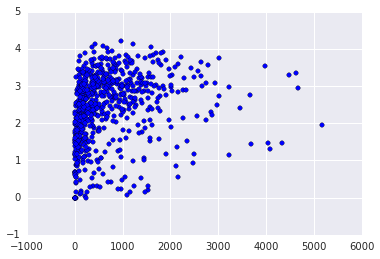

In [227]:
x, y = [], []
for i in users:
    x.append(user_connections[i])
    y.append(user_entropy[i])

plt.scatter(x,y)

In [223]:
list(df_bluetooth[df_bluetooth['user'] == 60]['bt_mac'])

[-1924633, -1924633, -1924633]

In [232]:
compute_entropy([0.9,0.05,0.05])

0.39439769144744274